In [1]:
from geopandas import read_file, GeoDataFrame
from pandas import merge, DataFrame

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import colors

from numpy import array

In [2]:
gdf = read_file('Data/Cat_Crim_Censo_SeccionesCDMX.shp').to_crs('EPSG:32614')

In [3]:
delis = ['DELITO DE',
        'FEMINICIDI',
        'HECHO NO D',
        'HOMICIDIO',
        'LESIONES D',
        'PLAGIO O S',
        'ROBO A CAS',
        'ROBO A CUE',
        'ROBO A NEG',
        'ROBO A PAS',
        'ROBO A P_1',
        'ROBO A P_2',
        'ROBO A REP',
        'ROBO A TRA',
        'ROBO A T_1',
        'ROBO DE VE',
        'SECUESTRO',
        'VIOLACIÓN']
delis = gdf[delis+['CVE_SECCIO']]

delis.loc[:,'delitos']=delis.sum(axis=1).copy()

/home/raul/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/raul/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [4]:
censo = gdf[['POBTOT','GRAPROES','PDESOCUP','CVE_SECCIO']]
catastro = gdf[['valor_unit','CVE_SECCIO','geometry']]

In [5]:
data = merge(delis.iloc[:,-2:],censo,on='CVE_SECCIO')

In [6]:
data['delitos'] = 100*data['delitos']/data['POBTOT']
data['PDESOCUP'] = 100*data['PDESOCUP']/data['POBTOT']
#data['POBTOT'] = 100*data['POBTOT']/data['POBTOT'].sum()

In [7]:
data = GeoDataFrame(merge(data,catastro,on='CVE_SECCIO'))

In [8]:
data['POBTOT'] = data.POBTOT/data.area

In [9]:
scaler = StandardScaler()
for i in ['delitos','POBTOT','GRAPROES','PDESOCUP','valor_unit']:
    data[i]=scaler.fit_transform(array(data[i]).reshape(-1,1)).reshape(len(data[i]),)

'''    
scaler = MinMaxScaler()
for i in ['delitos','POBTOT','GRAPROES','PDESOCUP','valor_unit']:
    data[i]=scaler.fit_transform(array(data[i]).reshape(-1,1)).reshape(len(data[i]),)
    
'''   

"    \nscaler = MinMaxScaler()\nfor i in ['delitos','POBTOT','GRAPROES','PDESOCUP','valor_unit']:\n    data[i]=scaler.fit_transform(array(data[i]).reshape(-1,1)).reshape(len(data[i]),)\n    \n"

In [10]:
data.drop(columns='delitos',inplace=True)

In [11]:
kmeans = KMeans(n_clusters=4, n_init=20, max_iter=600, random_state=123).fit(data.iloc[:,1:-1])

In [12]:
data['label'] = kmeans.labels_

In [13]:
munis = read_file('Data/munis/09mun.shp').to_crs('EPSG:32614')

In [14]:
clus = data.groupby('label').mean().round(3).reset_index()
#clus['delitos'] = clus['delitos']*10
#clus['GRAPROES'] = clus['GRAPROES']/10
#clus['valor_unit'] = clus['valor_unit']/10

In [15]:
clus

,label,POBTOT,GRAPROES,PDESOCUP,valor_unit
0,0,1.193,-0.641,-0.161,-0.320
1,1,-0.550,1.466,-0.362,1.269
2,2,-0.027,0.150,1.355,-0.056
3,3,-0.451,-0.462,-0.443,-0.448


In [55]:
y=['label','Densidad pobla-\ncional (0.47)', 'Grado de es-\ntudio (0.60)', 'Población deso-\ncupada (0.47)', 'Valor catas-\ntral (0.42)']
clus.rename(columns={i:j for i,j in zip(clus.columns,y)},inplace=True)

In [56]:
 plt.rcParams["font.family"] = 'serif' 

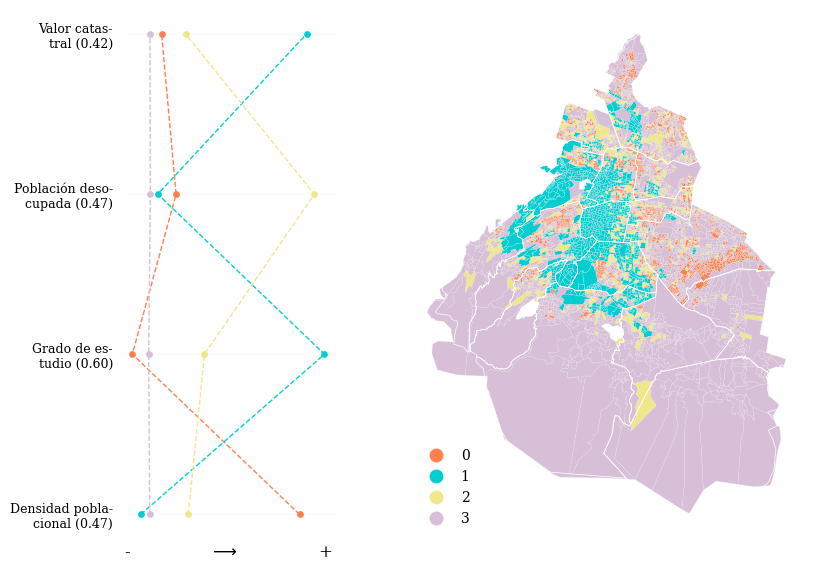

In [65]:
fig,ax = plt.subplots(1,2,figsize=(9,7),dpi=100, gridspec_kw={'height_ratios': [1],'width_ratios': [1,2]})
#fig.suptitle('Análisis de agrupamiento para secciones electorales\nen la CDMX.',color='black',fontsize=20,y=1)

lcolors = ['coral','darkturquoise','khaki','thistle']
hmap = colors.ListedColormap(lcolors)

fig.patch.set_facecolor('white')

data.plot(column='label',categorical=True,cmap=hmap,legend=True,linewidth=.15,ec='#E8E8E8',ax=ax[1], legend_kwds={'loc': 'lower left',
                                                                                                                'frameon' : False,
                                                                                                                'labelcolor' : 'black'})
munis.boundary.plot(ax=ax[1],linewidth=.5,color='w')

for i,c in zip(clus.label,lcolors):
    dp = clus[clus.label==i]
    ax[0].plot(array(dp.iloc[:,1:])[0],dp.columns[1:],linestyle='--',color=c,linewidth=1)
    ax[0].scatter(array(dp.iloc[:,1:])[0],dp.columns[1:],c=c,s=15)

ax[0].tick_params(axis='y', colors='black')
ax[1].axis('off')
#ax[0].set_facecolor('#0a0a0a')
#ax[1].set_facecolor('black')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].get_xaxis().set_ticks([])
ax[0].set_xlabel('-\t\t$\\longrightarrow$\t\t+',color='black',fontsize=12)
ax[0].tick_params(left=False,labelsize=9)
ax[0].grid(axis='y',linestyle='--',linewidth=.1,alpha=.6)
#ax[0].get_yaxis().set_ticks([])
    
plt.savefig('mapaF_w.png',dpi=600,bbox_inches='tight')
plt.show()

In [123]:
data.to_file('DoneData/clusterData.shp',index=False)